# Item Based Collaborative Filtering 

In [2]:
# We will use the same Train and Test Splits to do Item Base CF. 
# import pandas as pd 
# X_train = pd.read_csv("~/movie_lens_train.csv")
# X_test = pd.read_csv("~/movie_lens_test.csv")
# X_train.head()
# X_test.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,9419,63,16,5.0,1075307025
1,91703,607,4963,4.5,1113319563
2,10848,73,3967,3.5,1255849638
3,65877,468,1198,3.5,1296195555
4,75168,522,1220,5.0,1391349962


In [3]:
## Find Item Similarity 
#USING PYTHON - 
import math
from collections import defaultdict


import pandas as pd
import scipy as scipy
import numpy as np
from sklearn.model_selection import train_test_split

# ratings = pd.read_csv("~/Desktop/ml-latest-small 3/ratings.csv")
# print(ratings.head())
# sample_train, sample_test, sampleY_train, sampleY_test = train_test_split(ratings, ratings['rating'], test_size=0.20, random_state=42)
# len(sample_train['userId'].unique())

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


671

## Item-Item Similarity using Pearson Correlation Coefficient 

In [168]:
def item_similarity(sample_train1):
    item_sim = defaultdict(lambda : defaultdict(dict))
    outer_loop = 0
    count = 0
    update=0
    for item1_array in np.nditer(unique_items):
        item1 = item1_array.flat[0]
        item1_df = sample_train1.loc[sample_train1['movieId'] == item1]
        item1_users_set = set(item1_df['userId'])
        mean_rating1 = np.mean(item1_df['rating'])
        outer_loop+=1
        inner_loop = 0
        for item2_array in np.nditer(unique_items):
            inner_loop+=1
            count+=1
            item2 = item2_array.flat[0]
            if item1 == item2:
                item_sim[item1][item2] = 1
                item_sim[item2][item1] = 1
                continue
            if not item_sim[item1][item2] and item_sim[item1][item2] != 0:
                # find similarities between items
                # find intersection of users who rated Item 1 and Item 2
                update+=1
                item2_df = sample_train1.loc[sample_train1['movieId'] == item2]
                mean_rating2 = np.mean(item2_df['rating'])
                item2_users_set = set(item2_df['userId'])
                common_users = item1_users_set.intersection(item2_users_set)
                rating1 = item1_df[item1_df['userId'].isin(common_users)]['rating']
                rating2 = item2_df[item2_df['userId'].isin(common_users)]['rating']

                num = 0
                den1 = 0
                den2 =0
                for r1, r2 in zip(rating1, rating2):
                    r1_diff = r1 - mean_rating1
                    r2_diff = r2 - mean_rating2
                    num += r1_diff*r2_diff
                    den1 += r1_diff**2
                    den2 += r2_diff**2
                den = math.sqrt(den1)*math.sqrt(den2)
                if len(common_users) == 0 or den == 0:
                    item_sim[item1][item2] = 0
                else:
                    item_sim[item1][item2] = num/den

                item_sim[item2][item1] = item_sim[item1][item2]
                if count % 10000 == 0:
                    print('outer_loop='+str(outer_loop), 'inner_loop='+str(inner_loop), 'count='+str(count), 'update='+str(update))

    persist_data("item_sim.json", item_sim)
    return item_sim
def item_sim():
    return random.uniform(0,1) 
def give_k_sim(list_of_movies_for_user, top_k=None):
    if top_k:
            return k_item_sim(top_k)
    else:
            return k_item_sim(len(list_of_movies_for_user))
def k_item_sim(k):
    return sorted([item_sim() for x in range(k)],reverse=True)[0:k]
print(sample_test.head())

       userId  movieId  rating   timestamp
19090     128     1028     5.0  1049690908
99678     665     4736     1.0  1010197684
18455     120     4002     3.0  1167420604
35755     257     1274     4.0  1348544094
66536     468     6440     4.0  1296191715


### N similar items in neighborhood 

In [ ]:
# N similar items in neighborhood 
import collections
def sorted_dict_for_item_sim(user, movieId, k):
    # Here, use item similarity here
    try:
        # get item sim dict for movieId
        movie_sim=user_similarity[str(int(movieId))]
    except:
        return dict()
    list_of_movies_for_user = user_movie_dict[str(int(user))]
    # Here, we find the similarity of the movie of interest 
    dict_you_want = { m: movie_sim[str(int(m))] for m in list_of_movies_for_user }
    #print(len(dict_you_want),len(u_sim),len(user_of_interst), dict_you_want)
    sorted_x = sorted(dict_you_want.items(), key=lambda kv: kv[1], reverse=True)
    od=OrderedDict(sorted_x[0:k+1])
    od.pop(movieId,None)
    return od
sorted_dict_for_item_sim(641,31,3)

# Rating Prediction

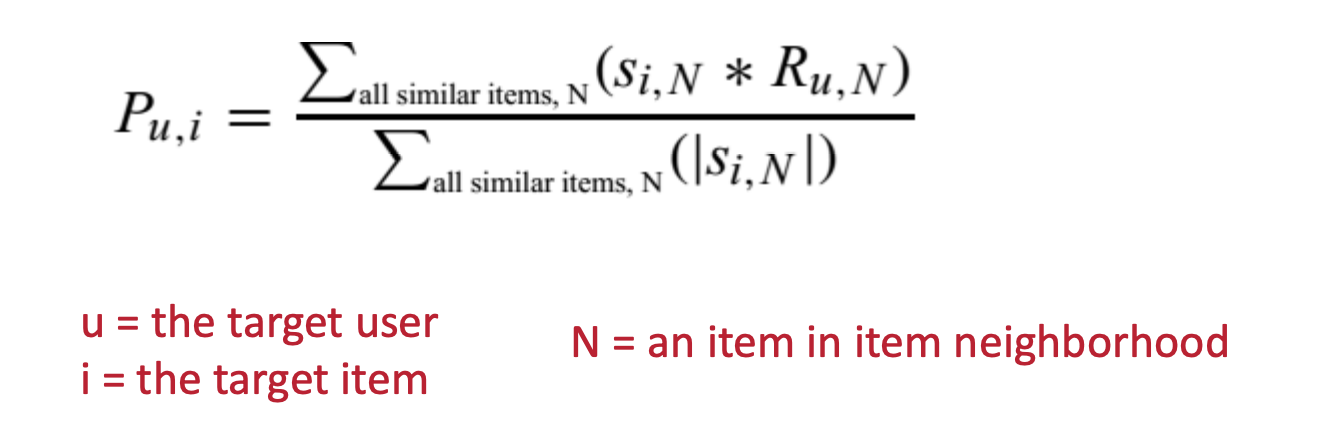

In [44]:
from IPython.display import Image
Image(filename='project_images/g.png', width = 600, height = 600)

In [169]:
# Make Predictions 
def prediction(min_sim=0, top_k=10):
    list_tuple = []
    
    for row in sample_test.iterrows():
        userId = row[1]['userId']
        movieId = row[1]['movieId']
        rating = row[1]['rating']
        list_of_movies_for_user = user_movie_dict[str(int(userId))]
        top_k_ratings=give_k_sim(list_of_movies_for_user, top_k)
        #print(top_k_ratings)
        num = 0
        den = 0
        for m,item_sim in zip(list_of_movies_for_user[0:top_k],top_k_ratings):
            if m==str(int(movieId)):
                      continue
            elif min_sim > item_sim:
                      break
            else:
                user_mean = user_mean_rating[str(int(userId))]
                rating_movie = sample_train.loc[(sample_train['movieId'] == float(m)) &(sample_train['userId'] == float(userId))]['rating'].item()        
#             print(rating_movie)
                 
                num += (rating_movie * item_sim)
                den += item_sim
#                 print(num,den) 
        if den == 0:
#             print('sim',item_sim, top_k_ratings[0])
            prediction = 0
        else:
             prediction = num/den  
        list_tuple.append((userId, movieId, rating, prediction))
    return list_tuple

          
opt_predictions = prediction(top_k=10)
opt_predictions[0:2]

[(128.0, 1028.0, 5.0, 3.8427455122092162),
 (665.0, 4736.0, 1.0, 3.104522697942651)]

## Step 3:  Accuracy Measures - MAE and RMSE

In [170]:
from sklearn.metrics import mean_absolute_error
def mae(list_tuple):
    truth = [t[2] for t in list_tuple]
    pred = [t[3] for t in list_tuple]
    truth_array = np.array(truth)
    pred_array = np.array(pred)
    return mean_absolute_error(truth_array, pred_array)

def rmse(list_tuple):
    truth = [t[2] for t in list_tuple]
    pred = [t[3] for t in list_tuple]
    truth_array = np.array(truth)
    pred_array = np.array(pred)
    return np.sqrt(((truth_array - pred_array) ** 2).mean())


print(mae(opt_predictions), rmse(opt_predictions))

0.7881629893101902 1.0140846375999801


### Scatter Plot 
#### Truth Vs Prediction 

In [171]:
import matplotlib.pyplot as plt
def plot_error(list_tuple):
    truth = [t[2] for t in list_tuple]
    pred = [t[3] for t in list_tuple]



    plt.scatter(truth,pred)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title('Truth Vs Prediction')
    
    plt.show()

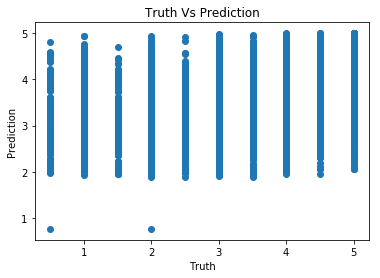

In [172]:
plot_error(opt_predictions)


## Violin Plot

/Users/priyankaagrawal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


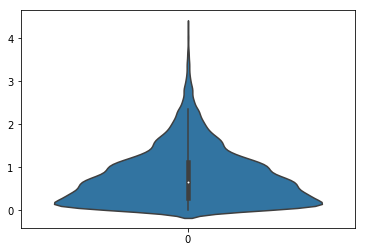

In [101]:
import seaborn as sns

def vodoo(list_tuple):
    error = [abs(t[2]-t[3]) for t in list_tuple]
    ax = sns.violinplot(data=pd.Series(error))
#vodoo(predictions)
vodoo(opt_predictions)

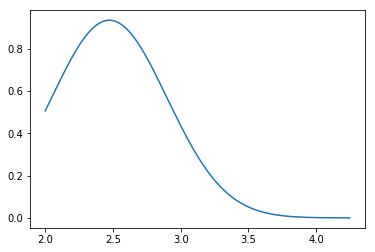

(2.472977174234535, 0.4271643471228093, 4.248292994260976)

In [137]:

np_error=np.array(error)
e=sorted(error,reverse=True)
np.mean(np_error)
np.std(np_error)
#x=np.linspace(0, 4, len(error))
plt.plot(e, norm.pdf(e, np.mean(np_error), np.std(np_error)))
plt.show()
np.mean(np_error),np.std(np_error), e[0]
#sorted(error,reverse=True)[0]
# error[0]

In [173]:
# Threshold check - checks if the absolute value of rating diff is greater than or equals threshold value. 

def threshold_check(list_tuple, threshold=2):

    too_much_error=[]
    error=[]
    for t in list_tuple:
         if abs(t[2]-t[3]) >= threshold:
            too_much_error.append(t)
            error.append(abs(t[2]-t[3]) )
    return len(too_much_error), len(list_tuple),too_much_error[1:10],error
#threshold_check(predictions)
a,b,error_list,error=threshold_check(opt_predictions)
a

1080